In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])

In [22]:
print shape(uni_x)
print uni_x[5]

(100,)
0.2


In [23]:
print shape(uni_x[:, None])
print (uni_x[:, None])[5]

(100, 1)
[ 0.2]


In [24]:
print shape(uni_y)
print type(uni_y)
print uni_y[5]
print type(uni_y)

(100,)
<type 'numpy.ndarray'>
0.2
<type 'numpy.ndarray'>


In [25]:
print shape(uni_y[:, None])
print (uni_y[:, None])[5]
print type((uni_y[:, None])[5])

(100, 1)
[ 0.2]
<type 'numpy.ndarray'>


In [32]:
print(shape(M))
print(M[50,50])

(100, 100)
0.04


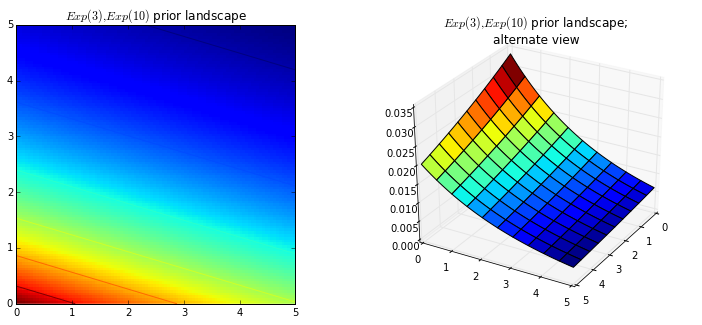

In [35]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")

#"Unsupervised clustering using a mixture model" 

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...
(300,)
300


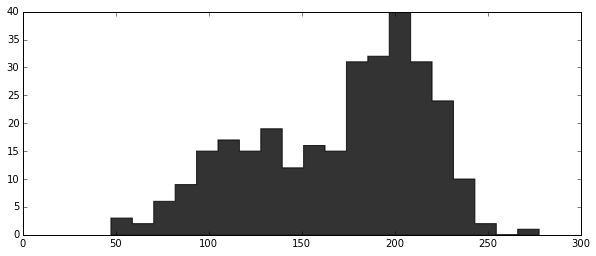

In [43]:
figsize(10, 4)
data = np.loadtxt('data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.ylim([0, None])
print data[:10], '...'
print data.shape  # (300,) - I think this is a tuple with one element
print data.shape[0]

In [46]:
import pymc as pm

p = pm.Uniform('p', 0, 1)

assignment = pm.Categorical('assignment', [p, 1-p], size=data.shape[0])
print 'prior assignment, with p = %.2f:' % p.value
print assignment.value[:10], '...'

prior assignment, with p = 0.40:
[0 0 1 1 0 1 1 1 1 0] ...


In [47]:
taus = 1.0 / pm.Uniform('stds', 0, 100, size=2) ** 2
centers = pm.Normal('centers', [120, 190], [0.01, 0.01], size=2)

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print 'random assignments: ', assignment.value[:4], '...'
print 'assigned center: ', center_i.value[:4], '...'
print 'assigned precision: ', tau_i.value[:4], '...'

random assignments:  [0 0 1 1] ...
assigned center:  [ 119.32106332  119.32106332  189.33694459  189.33694459] ...
assigned precision:  [ 0.00116118  0.00116118  0.00146402  0.00146402] ...


In [48]:
obs = pm.Normal('obs', center_i, tau_i, value=data, observed=True)

model = pm.Model([p, assignment, obs, taus, centers])

In [49]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 21.2 sec